In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np
from numpy import random

from scipy.stats import chi2
from scipy.special import erfcinv
from scipy.linalg import sqrtm, inv


import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

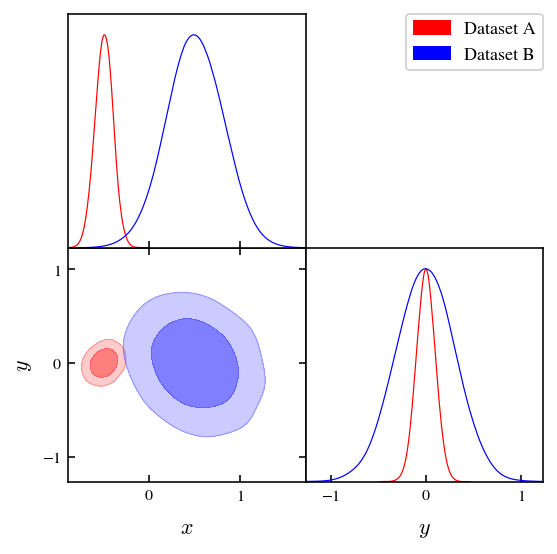

In [2]:
#Sharp triangle
num_datasets=2
num_parameters=2
df=num_datasets*num_parameters
num_samples=int(1e5)


mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])

cov_A = np.array([[1, 0.2], [0.2, 1]])/100
cov_B = np.array([[1, -0.2], [-0.2, 1]])/10

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')


colors = ['red', 'blue']

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)
g.export('triangle_plot_Qdm.pdf')




In [3]:
beta = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B)))
PTE = chi2.sf(beta, df)
n_sigma_beta = np.sqrt(2)*erfcinv(PTE)
print(n_sigma_beta)

1.933958952046063


In [4]:
rand_mean_A = random.multivariate_normal(mean_A, cov_A, num_samples)
rand_mean_B = random.multivariate_normal(mean_B, cov_B, num_samples)
output = np.zeros((num_samples))
for i in range(num_samples):
    mean_A = rand_mean_A[i]
    mean_B = rand_mean_B[i]

    beta = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B)))
    PTE = chi2.sf(beta, df)
    n_sigma_beta = np.sqrt(2)*erfcinv(PTE)
    output[i] = n_sigma_beta

Mean: 2.148719628265378
Median: 2.117509181642166
Std: 1.0165798547432343


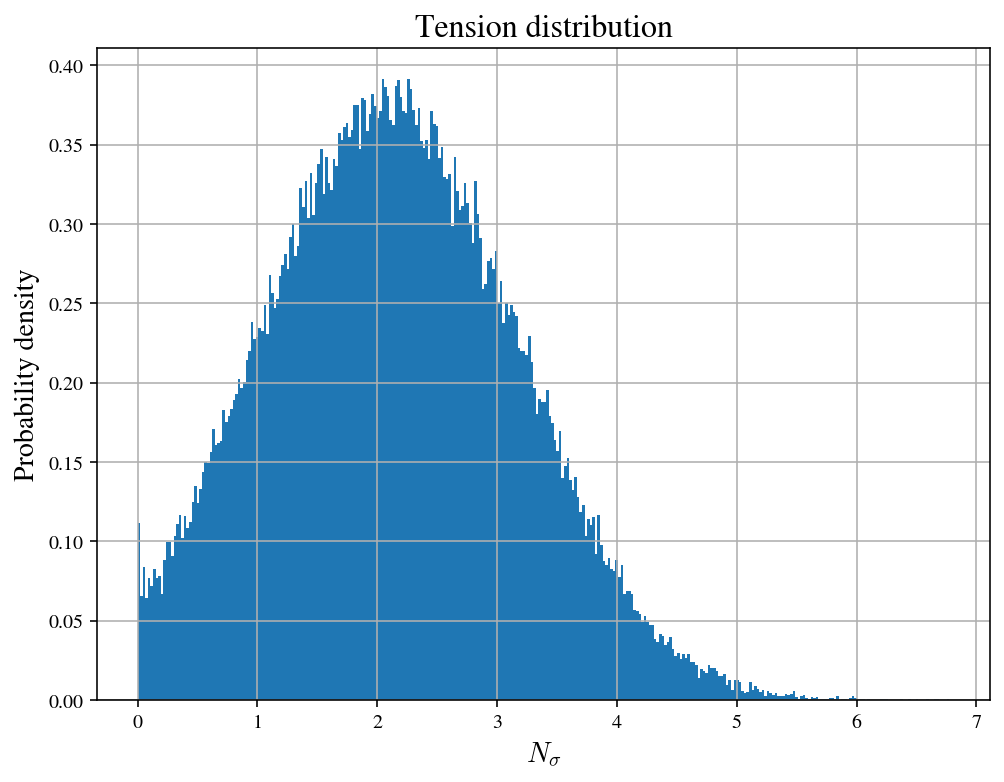

In [5]:
print('Mean:', np.mean(output))
print('Median:', np.median(output))

print('Std:', np.std(output))

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Tension distribution', fontsize=16)
ax.set_xlabel(r'$N_\sigma$', fontsize=14)
ax.set_ylabel('Probability density', fontsize=14)
ax.grid()
ax.hist(output, bins=int(np.sqrt(num_samples)), density=True)
fig.savefig('n_sigma_distribution_Qdm.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [6]:
# Calcular el histograma
hist, bin_edges = np.histogram(output, bins=int(np.sqrt(num_samples)), density=True)

# Encontrar el índice del bin con la mayor frecuencia
max_bin_index = np.argmax(hist)

# Calcular la moda como el centro del bin con la mayor frecuencia
mode = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2
print('Moda del histograma:', mode)

Moda del histograma: 2.26144553767854


Conviene usar la moda porque al ser una guassiana cortada la media, mediana y moda no coinciden. Notar que ademas la moda es la que mas se parece a Q_{DM}

Hay 2 preguntas distintas:
- Vamos a asignarle una precision a nuestro estimador? Si
- a) Si la precision viene de como calculamos el estimador y si lo hicimos con cadenas. La media dada por la cadena, con mas puntos en la cadena tendriamos una media mas precisa (el error en la media va como sqrt(N)).
- b) Posibles variaciones en las medias de los datatasets que vienen de los experimentos que usamos estimar los posteriors.
- c) Para estimar el error en Q_DM no hay que samplear con laa cov de la distribucino sino con el error en la media (pensar como!).

Otra cosa para pensar:
- Las medias tienen errores mas chicos que las covaarianzas. El estimador de las medias deberia tener un error mas chico que la posterior total.